In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.2MB 7.9MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)


In [0]:
import pandas as pd

DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

path = "/content/drive/My Drive/data/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [0]:
df.head() 

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 3
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [0]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [0]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 525 ms, sys: 7.54 ms, total: 533 ms
Wall time: 534 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

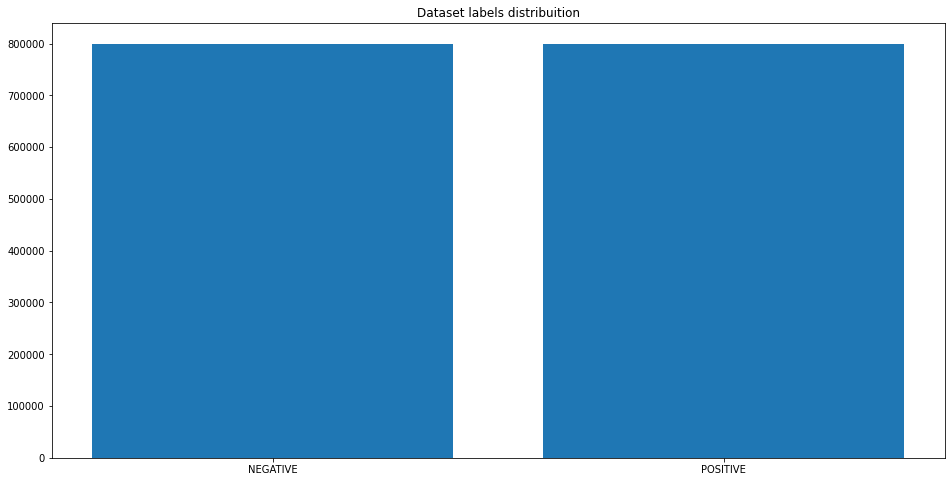

In [0]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [0]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [0]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 46.8 s, sys: 143 ms, total: 47 s
Wall time: 47 s


In [0]:
TRAIN_SIZE=0.8

df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [0]:
%%time
documents = [_text.split() for _text in df_train.text] 


CPU times: user 2.72 s, sys: 456 ms, total: 3.18 s
Wall time: 3.19 s


In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [0]:
w2v_model.build_vocab(documents)

2020-05-05 18:07:07,745 : INFO : collecting all words and their counts
2020-05-05 18:07:07,746 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-05 18:07:07,774 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-05-05 18:07:07,795 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-05-05 18:07:07,815 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-05-05 18:07:07,839 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-05-05 18:07:07,859 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-05-05 18:07:07,881 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-05-05 18:07:07,906 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-05-05 18:07:07,928 : INFO : PROGRESS: at s

In [0]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [0]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-05-05 18:07:17,264 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-05-05 18:07:18,350 : INFO : EPOCH 1 - PROGRESS: at 4.13% examples, 317799 words/s, in_qsize 16, out_qsize 0
2020-05-05 18:07:19,396 : INFO : EPOCH 1 - PROGRESS: at 8.80% examples, 341871 words/s, in_qsize 15, out_qsize 0
2020-05-05 18:07:20,431 : INFO : EPOCH 1 - PROGRESS: at 13.14% examples, 342581 words/s, in_qsize 14, out_qsize 1
2020-05-05 18:07:21,442 : INFO : EPOCH 1 - PROGRESS: at 17.78% examples, 351353 words/s, in_qsize 14, out_qsize 1
2020-05-05 18:07:22,594 : INFO : EPOCH 1 - PROGRESS: at 22.44% examples, 347364 words/s, in_qsize 15, out_qsize 0
2020-05-05 18:07:23,701 : INFO : EPOCH 1 - PROGRESS: at 27.31% examples, 349935 words/s, in_qsize 14, out_qsize 2
2020-05-05 18:07:24,703 : INFO : EPOCH 1 - PROGRESS: at 31.86% examples, 353104 words/s, in_qsize 15, out_qsize 0
2020-05-05 18:07:25,788 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 23min 34s, sys: 5.54 s, total: 23min 40s
Wall time: 12min 7s


(263125537, 295270528)

In [0]:
w2v_model.most_similar("awesome")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-05-05 18:19:24,511 : INFO : precomputing L2-norms of word weight vectors


[('amazing', 0.7794113159179688),
 ('great', 0.6846311688423157),
 ('fantastic', 0.6324511766433716),
 ('awsome', 0.5763086676597595),
 ('cool', 0.5393363237380981),
 ('incredible', 0.5287753343582153),
 ('fab', 0.49834758043289185),
 ('love', 0.4627910256385803),
 ('good', 0.45397692918777466),
 ('excellent', 0.4516769051551819)]

In [0]:
df_train

,target,ids,date,flag,user,text
1374558,POSITIVE,2051457557,Fri Jun 05 22:04:23 PDT 2009,NO_QUERY,JGoldsborough,ya quot like palm pre touchstone charger ready...
1389115,POSITIVE,2053083567,Sat Jun 06 03:12:21 PDT 2009,NO_QUERY,Psioui,felt earthquake afternoon seems epicenter
1137831,POSITIVE,1976779404,Sat May 30 19:02:49 PDT 2009,NO_QUERY,adriville,ruffles shirts like likey
790714,NEGATIVE,2325739990,Thu Jun 25 05:59:18 PDT 2009,NO_QUERY,Blondie128,pretty bad night crappy morning fml buttface d...
1117911,POSITIVE,1973503391,Sat May 30 11:16:35 PDT 2009,NO_QUERY,khrabrov,yeah clear view
...,...,...,...,...,...,...
259178,NEGATIVE,1985361990,Sun May 31 16:57:39 PDT 2009,NO_QUERY,lutheasalom,song middle change want born arghhhh
1414414,POSITIVE,2057029784,Sat Jun 06 12:14:24 PDT 2009,NO_QUERY,beeluz,good luck
131932,NEGATIVE,1835639354,Mon May 18 06:26:21 PDT 2009,NO_QUERY,lordmuttley,rather average 32370
671155,NEGATIVE,2246780174,Fri Jun 19 18:06:46 PDT 2009,NO_QUERY,MizSadittyFancy,pickin misstinayao waitin sadittysash 2 hurry ...


In [0]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 20.4 s, sys: 98 ms, total: 20.5 s
Wall time: 20.5 s


In [0]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 32.1 s, sys: 1.34 s, total: 33.4 s
Wall time: 33.5 s


In [0]:
x_train

array([[     0,      0,      0, ...,    712,    118,  24590],
       [     0,      0,      0, ...,    452,    378,  32447],
       [     0,      0,      0, ...,   2048,      4,   5487],
       ...,
       [     0,      0,      0, ...,    661,   4246, 290416],
       [     0,      0,      0, ...,     12,    477,    957],
       [     0,      0,      0, ...,      9,    502,    268]], dtype=int32)

In [0]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [0]:
df_train

,target,ids,date,flag,user,text
1374558,POSITIVE,2051457557,Fri Jun 05 22:04:23 PDT 2009,NO_QUERY,JGoldsborough,ya quot like palm pre touchstone charger ready...
1389115,POSITIVE,2053083567,Sat Jun 06 03:12:21 PDT 2009,NO_QUERY,Psioui,felt earthquake afternoon seems epicenter
1137831,POSITIVE,1976779404,Sat May 30 19:02:49 PDT 2009,NO_QUERY,adriville,ruffles shirts like likey
790714,NEGATIVE,2325739990,Thu Jun 25 05:59:18 PDT 2009,NO_QUERY,Blondie128,pretty bad night crappy morning fml buttface d...
1117911,POSITIVE,1973503391,Sat May 30 11:16:35 PDT 2009,NO_QUERY,khrabrov,yeah clear view
...,...,...,...,...,...,...
259178,NEGATIVE,1985361990,Sun May 31 16:57:39 PDT 2009,NO_QUERY,lutheasalom,song middle change want born arghhhh
1414414,POSITIVE,2057029784,Sat Jun 06 12:14:24 PDT 2009,NO_QUERY,beeluz,good luck
131932,NEGATIVE,1835639354,Mon May 18 06:26:21 PDT 2009,NO_QUERY,lordmuttley,rather average 32370
671155,NEGATIVE,2246780174,Fri Jun 19 18:06:46 PDT 2009,NO_QUERY,MizSadittyFancy,pickin misstinayao waitin sadittysash 2 hurry ...


In [0]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [0]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [0]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [0]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [0]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [0]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [0]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [0]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/3
1152000/1152000 [==============================] - 8220s 7ms/step - loss: 0.5066 - accuracy: 0.7480 - val_loss: 0.4662 - val_accuracy: 0.7784
Epoch 2/3


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152000/1152000 [==============================] - 8126s 7ms/step - loss: 0.4921 - accuracy: 0.7589 - val_loss: 0.4610 - val_accuracy: 0.7810
Epoch 3/3
1152000/1152000 [==============================] - 8098s 7ms/step - loss: 0.4812 - accuracy: 0.7658 - val_loss: 0.4553 - val_accuracy: 0.7844
CPU times: user 12h 26min 44s, sys: 39min 19s, total: 13h 6min 4s
Wall time: 6h 47min 25s


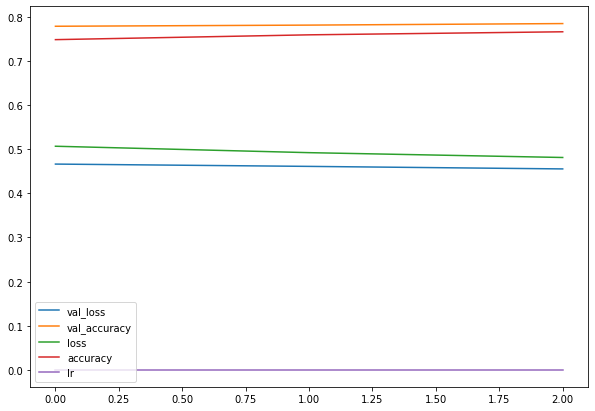

In [0]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(10,7))

In [0]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 694s 2ms/step

ACCURACY: 0.7854468822479248
LOSS: 0.4541092287063599
CPU times: user 21min 17s, sys: 56.9 s, total: 22min 14s
Wall time: 11min 33s


In [0]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [0]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [0]:
predict("I love the guitar but playing guitar is difficult")

{'elapsed_time': 0.1716294288635254,
 'label': 'POSITIVE',
 'score': 0.7896862626075745}